<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# KNN Classification and Imputation: Cell Phone Churn Data

_Authors: Kiefer Katovich (SF)_

---

In this lab you will practice using KNN for classification (and a little bit for regression as well).

The dataset is one on "churn" in cell phone plans. It has information on the usage of the phones by different account holders and whether or not they churned or not.

Our goal is to predict whether a user will churn or not based on the other features.

We will also be using the KNN model to **impute** missing data. There are a couple of columns in the dataset with missing values, and we can build KNN models to predict what those missing values will most likely be. This is a more advanced imputation method than just filling in the mean or median.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.neighbors import KNeighborsClassifier

### 1. Load the cell phone "churn" data containing some missing values.

In [3]:
churn = pd.read_csv('../data/churn_missing.csv')

churn.shape
churn.head()

,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,eve_calls,eve_charge,night_mins,night_calls,night_charge,intl_mins,intl_calls,intl_charge,custserv_calls,churn
0,KS,128,415,no,yes,25.0,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,no,yes,26.0,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,no,no,0.0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,yes,no,0.0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,yes,no,0.0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


### 2. Examine the data. What columns have missing values?

In [4]:
# A: We have 400 missing data each for vmail_plan and vmail_message
churn.isnull().sum()

state               0
account_length      0
area_code           0
intl_plan           0
vmail_plan        400
vmail_message     400
day_mins            0
day_calls           0
day_charge          0
eve_mins            0
eve_calls           0
eve_charge          0
night_mins          0
night_calls         0
night_charge        0
intl_mins           0
intl_calls          0
intl_charge         0
custserv_calls      0
churn               0
dtype: int64

### 3. Convert the `vmail_plan` and `intl_plan` colums to binary integer columns.

Make sure that if a value is missing that you don't fill it in with a new value! Preserve the missing values.

In [5]:
# A:
for i in churn.index:
    if churn.loc[i, 'vmail_plan']=='yes':
        churn.loc[i, 'vmail_plan']= 1
    elif churn.loc[i, 'vmail_plan']=='no':
        churn.loc[i, 'vmail_plan']= 0
for i in churn.index:
    if churn.loc[i, 'intl_plan']=='yes':
        churn.loc[i, 'intl_plan']= 1
    elif churn.loc[i, 'intl_plan']=='no':
        churn.loc[i, 'intl_plan']= 0
churn.vmail_plan
churn.vmail_plan.isnull().sum()
churn.intl_plan.dtype

dtype('O')

### 4. Create dummy coded columns for state and concatenate it to the churn dataset.

> **Remember:** You will need to leave out one of the state dummy coded columns to serve as the "reference" column since we will be using these for modeling.

In [6]:
# A: Notice when get_dummies, always get rid of one unncessary dummy column which is the balance of the rest
state_dummy = pd.get_dummies(churn.state, prefix='state',drop_first=True)
state_dummy.head()

,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DC,state_DE,state_FL,state_GA,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
# DC is counted as a state
len(churn.state.unique())

51

In [8]:
churn = pd.concat([churn, state_dummy], axis=1)

In [9]:
churn.shape

(3333, 70)

### 5. Create a version of the churn data that has no missing values.

Calculate the shape

In [10]:
# A: drop all null rows from dataframe
churn1 = churn.dropna()
churn1.isnull().sum()
# convert string to integers for intl_plan and vmail_plan columns
cols= ['intl_plan', 'vmail_plan']
churn1[cols] = churn1[cols].astype('int64')
churn1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2933 entries, 0 to 3332
Data columns (total 70 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   state           2933 non-null   object 
 1   account_length  2933 non-null   int64  
 2   area_code       2933 non-null   int64  
 3   intl_plan       2933 non-null   int64  
 4   vmail_plan      2933 non-null   int64  
 5   vmail_message   2933 non-null   float64
 6   day_mins        2933 non-null   float64
 7   day_calls       2933 non-null   int64  
 8   day_charge      2933 non-null   float64
 9   eve_mins        2933 non-null   float64
 10  eve_calls       2933 non-null   int64  
 11  eve_charge      2933 non-null   float64
 12  night_mins      2933 non-null   float64
 13  night_calls     2933 non-null   int64  
 14  night_charge    2933 non-null   float64
 15  intl_mins       2933 non-null   float64
 16  intl_calls      2933 non-null   int64  
 17  intl_charge     2933 non-null   f

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


### 6. Create a target vector and predictor matrix.

- Target should be the `churn` column.
- Predictor matrix should be all columns except `area_code`, `state`, and `churn`.

In [11]:
# A:
y = churn1.churn.values
X = churn1.drop(['area_code','state','churn'], axis=1)
X.shape
y.shape

(2933,)

In [12]:
X.vmail_plan 
X.isnull().sum()
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2933 entries, 0 to 3332
Data columns (total 67 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   account_length  2933 non-null   int64  
 1   intl_plan       2933 non-null   int64  
 2   vmail_plan      2933 non-null   int64  
 3   vmail_message   2933 non-null   float64
 4   day_mins        2933 non-null   float64
 5   day_calls       2933 non-null   int64  
 6   day_charge      2933 non-null   float64
 7   eve_mins        2933 non-null   float64
 8   eve_calls       2933 non-null   int64  
 9   eve_charge      2933 non-null   float64
 10  night_mins      2933 non-null   float64
 11  night_calls     2933 non-null   int64  
 12  night_charge    2933 non-null   float64
 13  intl_mins       2933 non-null   float64
 14  intl_calls      2933 non-null   int64  
 15  intl_charge     2933 non-null   float64
 16  custserv_calls  2933 non-null   int64  
 17  state_AL        2933 non-null   u

### 7. Calculate the baseline accuracy for `churn`.

In [17]:
# A:
most_freq_class = y.value_counts().index[0]
# most frequent churn position is False
print(y.value_counts())
most_freq_class
# calculate baseline accuracy assuming all responses are False
y.value_counts()[most_freq_class] / len(y)

False    2512
True      421
Name: churn, dtype: int64


0.8564609614728946

In [13]:
# another way to calculate is this
churn1.churn.mean()

0.14353903852710534

In [15]:
baseline = 1. - churn1.churn.mean()
print(baseline)

0.8564609614728946


### 8. Cross-validate a KNN model predicting `churn`. 

- Number of neighbors should be 5.
- Make sure to standardize the predictor matrix.
- Set cross-validation folds to 10.

Report the mean cross-validated accuracy.

In [16]:
# A:
from sklearn import model_selection
kf = model_selection.KFold(n_splits=10, shuffle=True, random_state=42)
from sklearn.model_selection import cross_val_score
from sklearn import metrics
# A:standardize the predictor matrix
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [17]:
knn = KNeighborsClassifier(n_neighbors = 5)
scores = cross_val_score(knn, X, y, cv=10)
print(scores)
print(np.mean(scores))

[0.85034014 0.85714286 0.85714286 0.85665529 0.87030717 0.85665529
 0.85665529 0.85324232 0.85665529 0.85665529]
0.8571451788906689


### 9. Iterate from k=1 to k=49 (only odd k) and cross-validate the accuracy of the model for each.

Plot the cross-validated mean accuracy for each score. What is the best accuracy?

In [19]:
# A:
k_values = list(range(1,50,2))
accs = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=10)
    accs.append(np.mean(scores))

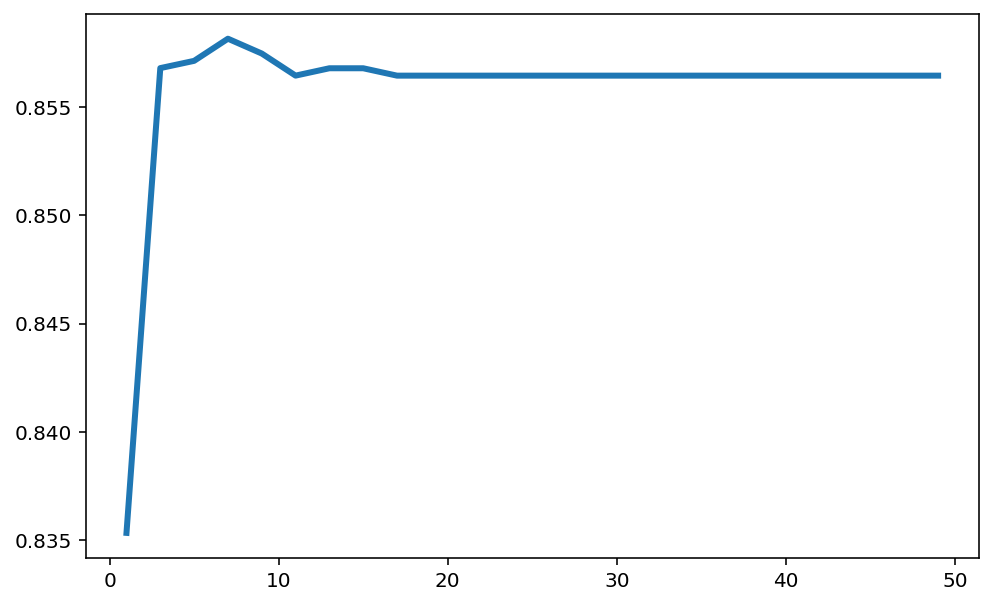

0.8581690696756518


In [20]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(k_values, accs, lw=3)
plt.show()

print(np.max(accs))

### 10. Imputing with KNN

K-Nearest Neighbors can be used to impute missing values in datasets. What we will do is estimate the most likely value for the missing data based on a KNN model.

We have two columns with missing data:
- `vmail_plan`
- `vmail_message`

**10.A Create two subsets of the churn dataset: one without missing values for `vmail_plan` and `vmail_message`, and one with the missing values.**

In [46]:
# A:
from sklearn.neighbors import KNeighborsRegressor
missing_cols = ['vmail_plan','vmail_message']
impute_missing = churn.loc[churn.vmail_plan.isnull(), :]
impute_valid = churn.loc[~churn.vmail_plan.isnull(), :]
impute_missing.head()
impute_valid.head()

,state,account_length,area_code,intl_plan,vmail_plan,vmail_message,day_mins,day_calls,day_charge,eve_mins,...,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,KS,128,415,0,1,25.0,265.1,110,45.07,197.4,...,0,0,0,0,0,0,0,0,0,0
1,OH,107,415,0,1,26.0,161.6,123,27.47,195.5,...,0,0,0,0,0,0,0,0,0,0
2,NJ,137,415,0,0,0.0,243.4,114,41.38,121.2,...,0,0,0,0,0,0,0,0,0,0
3,OH,84,408,1,0,0.0,299.4,71,50.90,61.9,...,0,0,0,0,0,0,0,0,0,0
4,OK,75,415,1,0,0.0,166.7,113,28.34,148.3,...,0,0,0,0,0,0,0,0,0,0


First we will impute values for `vmail_plan`. This is a categorical column and so we will impute using classification (predicting whether the plan is yes or no, 1 vs. 0).

**10.B Create a target that is `vmail_plan` and predictor matrix that is all columns except `state`, `area_code`, `churn`, `vmail_plan`, and `vmail_message`.**

> **Note:** We don't include the `churn` variable in the model to impute. Why? We are imputing these missing values so that we can use the rows to predict churn with more data afterwards. If we imputed with churn as a predictor then we would be cheating.

In [47]:
# A:
impute_cols = [c for c in impute_valid.columns if not c in ['state','area_code','churn']+missing_cols]
y = impute_valid.vmail_plan.values.astype('int64')
X = impute_valid[impute_cols]
y.dtype
impute_cols

['account_length',
 'intl_plan',
 'day_mins',
 'day_calls',
 'day_charge',
 'eve_mins',
 'eve_calls',
 'eve_charge',
 'night_mins',
 'night_calls',
 'night_charge',
 'intl_mins',
 'intl_calls',
 'intl_charge',
 'custserv_calls',
 'state_AL',
 'state_AR',
 'state_AZ',
 'state_CA',
 'state_CO',
 'state_CT',
 'state_DC',
 'state_DE',
 'state_FL',
 'state_GA',
 'state_HI',
 'state_IA',
 'state_ID',
 'state_IL',
 'state_IN',
 'state_KS',
 'state_KY',
 'state_LA',
 'state_MA',
 'state_MD',
 'state_ME',
 'state_MI',
 'state_MN',
 'state_MO',
 'state_MS',
 'state_MT',
 'state_NC',
 'state_ND',
 'state_NE',
 'state_NH',
 'state_NJ',
 'state_NM',
 'state_NV',
 'state_NY',
 'state_OH',
 'state_OK',
 'state_OR',
 'state_PA',
 'state_RI',
 'state_SC',
 'state_SD',
 'state_TN',
 'state_TX',
 'state_UT',
 'state_VA',
 'state_VT',
 'state_WA',
 'state_WI',
 'state_WV',
 'state_WY']

**10.C Standardize the predictor matrix.**

In [48]:
# A:
ss = StandardScaler()
Xs = ss.fit_transform(X)

**10.D Find the best K for predicting `vmail_plan`.**

You may want to write a function for this. What is the accuracy for predicting `vmail_plan` at the best K? What is the baseline accuracy for `vmail_plan`?

In [49]:
# A:
def find_best_k_cls(X, y, k_min=1, k_max=51, step=2, cv=5):
    k_range = list(range(k_min, k_max+1, step))
    accs = []
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X, y, cv=cv)
        accs.append(np.mean(scores))
    print(np.max(accs), np.argmax(k_range))
    return np.argmax(k_range)

**10.E Fit a `KNeighborsClassifier` with the best number of neighbors.**

In [50]:
# A:
find_best_k_cls(Xs, y)

0.7262193952009117 25


25

In [51]:
impute_valid.vmail_plan.mean()
# less than 0.5

0.27378111148994205

In [52]:
vmail_plan_baseline = 1. - impute_valid.vmail_plan.mean()
print(vmail_plan_baseline)

0.726218888510058


In [53]:
knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(Xs, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=25, p=2,
                     weights='uniform')

**10.F Predict the missing `vmail_plan` values using the subset of the data where it is misssing.**

You will need to:
1. Create a new predictor matrix using the same predictors but from the missing subset of data.
- Standardize this predictor matrix *using the StandardScaler object fit on the non-missing data*. This means you will just use the `.transform()` function. It is important to standardize the new predictors the same way we standardized the original predictors if we want the predictions to make sense. Calling `.fit_transform()` will reset the standardized scale.
- Predict what the missing vmail plan values should be.
- Replace the missing values in the original with the predicted values.

> **Note:** It may predict all 0's. This is OK. If you want to see the predicted probabilities of `vmail_plan` for each row you can use the `.predict_proba()` function instead of `.predict()`.  You can use these probabilities to manually set the criteria threshold.

In [54]:
# A:
X_miss = impute_missing[impute_cols]
X_miss_s = ss.transform(X_miss)
X_miss.info()
X_miss_s[:1]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 6 to 3317
Data columns (total 65 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   account_length  400 non-null    int64  
 1   intl_plan       400 non-null    object 
 2   day_mins        400 non-null    float64
 3   day_calls       400 non-null    int64  
 4   day_charge      400 non-null    float64
 5   eve_mins        400 non-null    float64
 6   eve_calls       400 non-null    int64  
 7   eve_charge      400 non-null    float64
 8   night_mins      400 non-null    float64
 9   night_calls     400 non-null    int64  
 10  night_charge    400 non-null    float64
 11  intl_mins       400 non-null    float64
 12  intl_calls      400 non-null    int64  
 13  intl_charge     400 non-null    float64
 14  custserv_calls  400 non-null    int64  
 15  state_AL        400 non-null    uint8  
 16  state_AR        400 non-null    uint8  
 17  state_AZ        400 non-null    ui

array([[ 0.49064183, -0.32100819,  0.72240585, -0.62272815,  0.72191326,
         2.94045993,  0.38866335,  2.93983277,  0.21790649,  0.91281112,
         0.21918897, -0.9954795 ,  1.04038146, -0.98955593,  1.10150956,
        -0.16088249, -0.12622795, -0.13565684, -0.09639047, -0.13695442,
        -0.14815944, -0.12898753, -0.13695442, -0.13951602, -0.12761472,
        -0.12622795, -0.11906738, -0.1445133 , -0.13434764, -0.15172534,
        -0.14327903, -0.14078066, -0.12761472,  7.0405231 , -0.14815944,
        -0.13824071, -0.14815944, -0.16528911, -0.13951602, -0.14695327,
        -0.14573796, -0.1420349 , -0.13695442, -0.13565684, -0.13034681,
        -0.14695327, -0.13824071, -0.14695327, -0.1540608 , -0.15289712,
        -0.14327903, -0.15750501, -0.11906738, -0.14078066, -0.13951602,
        -0.13565684, -0.12761472, -0.14327903, -0.14573796, -0.15172534,
        -0.15054527, -0.14327903, -0.1540608 , -0.17484056, -0.1540608 ]])

In [55]:
vmail_plan_impute = knn.predict(X_miss_s)
vmail_plan_impute

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [56]:
# creating a DF copy to use to imputed missing values
churn_imputed = churn.copy()
# filling missing vmail_plan values with those predicted by KNN model
churn_imputed.loc[churn.vmail_plan.isnull(), 'vmail_plan'] = vmail_plan_impute

### 11. Impute the missing values for `vmail_message` using the same process.

Since `vmail_message` is essentially a continuous measure, you need to use `KNeighborsRegressor` instead of the `KNeighborsClassifier`.

KNN can do both regression and classification! Instead of "voting" on the class like in classification, the neighbors will average their value for the target in regression.

In [57]:
# A:
def find_best_k_reg(X, y, k_min=1, k_max=51, step=2, cv=10):
    k_range = list(range(k_min, k_max+1, step))
    r2s = []
    for k in k_range:
        knn = KNeighborsRegressor(n_neighbors=k)
        scores = cross_val_score(knn, X, y, cv=cv)
        r2s.append(np.mean(scores))
    print(np.max(r2s), np.argmax(k_range))
    return np.argmax(k_range)

In [58]:
# x-true & y-true
y = impute_valid.vmail_message.values
X = impute_valid[impute_cols]

# set and fit the scaler
ss = StandardScaler()
Xs = ss.fit_transform(X)

# call/use find k-best function on known data
best_k = find_best_k_reg(Xs, y)

# apply k-best to fit model
knn = KNeighborsRegressor(n_neighbors=best_k)
knn.fit(Xs, y)

# prepair rows with missing target values
X_miss = impute_missing[impute_cols]
X_miss_s = ss.transform(X_miss)

# use model to predict unknown values
vmail_message_impute = knn.predict(X_miss_s)
vmail_message_impute

# this r2 is not very good

-0.034936418201589305 25


array([ 7.68,  8.28,  5.36,  8.48, 10.68,  6.  ,  8.68,  8.08,  9.32,
        7.8 ,  9.72,  3.8 ,  8.88,  4.2 ,  2.44, 11.72,  8.04,  6.88,
        8.08,  7.84, 11.76,  7.56,  8.12, 11.84,  5.16,  9.88, 15.48,
       10.04,  6.76, 11.72,  7.96,  7.68,  8.92,  8.88,  6.4 ,  7.36,
        9.72, 10.04, 11.  ,  5.16, 10.96,  7.4 ,  4.92, 11.4 , 10.36,
       10.56,  7.08,  8.72,  9.28,  6.24,  8.92,  7.84, 12.24,  6.84,
        4.24, 10.8 ,  5.72,  5.92,  4.76,  8.72,  6.88,  8.32,  6.92,
        9.04,  7.36,  9.2 ,  5.48,  2.92,  4.  , 11.2 ,  9.36,  7.84,
        7.76,  3.6 ,  8.2 ,  9.32, 10.2 ,  8.08,  7.8 , 10.12,  7.64,
       12.08,  8.52,  3.28,  8.72,  7.  ,  2.8 ,  9.12,  6.36,  9.2 ,
       11.88,  9.  ,  7.84, 10.8 ,  9.44,  5.72, 10.36, 10.52,  3.72,
        8.8 ,  4.72,  6.32,  8.36,  5.44,  6.8 ,  4.04,  3.88,  3.4 ,
        4.88,  5.28,  1.68,  9.28,  9.24,  9.28,  6.28,  9.8 ,  5.68,
        4.32,  3.8 ,  8.4 ,  9.12,  9.04,  4.2 ,  9.88, 11.32,  4.84,
        8.64, 11.  ,

In [59]:
# assign predicted values to missing values in dataframe
churn_imputed.loc[churn.vmail_message.isnull(), 'vmail_message'] = vmail_message_impute

### 12. Given the accuracy (and $R^2$) of your best imputation models when finding the best K neighbors, do you think imputing is a good idea?

In [18]:
# A: The accuracy and R2 are very bad. This our imputed values are most likely wrong with these models.
# This doesn't necessarily mean that imputation is a bad idea, but we may want to consider
# using a different method.

### 13. With the imputed dataset, cross-validate the accuracy predicting churn. Is it better? Worse? The same?

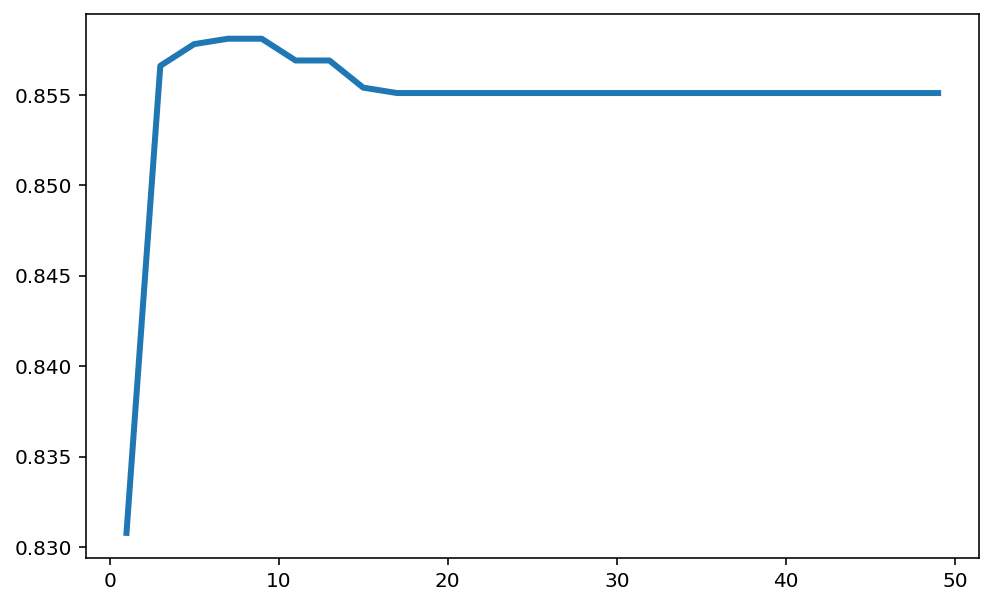

In [61]:
# A:
X = churn_imputed[[c for c in churn1.columns if not c in ['area_code','state','churn']]]
y = churn_imputed.churn.values

ss = StandardScaler()
Xs = ss.fit_transform(X)

k_values = list(range(1,50,2))
accs = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, Xs, y, cv=10)
    accs.append(np.mean(scores))
    
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(k_values, accs, lw=3)
plt.show()

In [62]:
print(np.max(accs))

0.8580892269515022


Its basically exactly the same. However the peak performance comes at about k=9. Given that our model using imputed data scores almost exactly the same and requires more neighbors to come reach optimal accuracy we would either want to investigate other means of imputation or utilize the original model as it is computationally more efficient.